In [1]:
import re
import jovian
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

<IPython.core.display.Javascript object>

## Data Preprocessing

* Regex cheatsheet
    * https://www.rexegg.com/regex-quickstart.html
* Regex test - live
    * https://regexr.com/
* Datetime format
    * http://strftime.org/

In [4]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding = 'utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

### Import data

In [6]:
df = rawToDf('WhatsApp Chat with Late.Oyolife blr1570sucks.txt', '24hr')

In [7]:
df.tail()

,date_time,user,msg
2132,2019-12-18 17:05:00,+91 94658 31285,2 months rent
2133,2019-12-18 17:08:00,Arbaz Oyo Supervisor,Ok
2134,2019-12-19 17:34:00,Adarsh Bhaiya,<Media omitted>
2135,2019-12-19 18:01:00,+91 97424 80334,Can anyone send Arjun number
2136,2019-12-20 07:33:00,+91 81055 57766,https://economictimes.indiatimes.com/small-biz...


In [8]:
df.shape # no. of msgs

(2137, 3)

In [9]:
me = "Papa"

### Data Cleaning

In [10]:
images = df[df['msg']=="<Media omitted> "] #no. of images, images are represented by <media omitted>
images.shape

(199, 3)

In [11]:
df["user"].unique()

array(['grp_notif', '+91 99865 06076', 'Dr Jay Flipkart',
       'Rahul Oyo Life', 'Adarsh Bhaiya', 'Papa', 'Arbaz Oyo Supervisor',
       'Saurav Sir 505', '210 Syed Bhaiya', '411 Oyolife 1570',
       '+91 96636 75725', 'Arnab Das Bhaiya Oyolife', '+91 89033 57556',
       '+91 99032 11464', '+91 81055 57766', '+91 94658 31285',
       'Ganesh Supervisor', '+91 95618 30358', '+91 91102 66076',
       '+91 85757 34259', 'Shehraz Bhaiya', '106 Oyolife', 'Abhishek 416',
       'Shamsia', '+91 74186 09457', 'Gaurav 408', '+91 93113 56939',
       'Punjaab De Puttar', 'Mahesh 415', '+91 85560 73035', 'Stree',
       'Krishna 303', 'Saloni Didi', '+91 95458 36388', '+91 70695 63023',
       'Aditya Tendulkar Bhaiya', '+91 70221 21359', '+91 72772 94766',
       '+91 82968 86915', '601 Rigjit', '+91 98196 03217',
       '+91 70058 30051', '+91 91486 71444', '+91 90086 69330',
       'Manish Oyo Area Manager', 'Ankit Bhaiya IIT', '+91 97424 80334'],
      dtype=object)

In [12]:
grp_notif = df[df['user']=="grp_notif"] #no. of grp notifications
grp_notif.shape

(30, 3)

In [13]:
df.drop(images.index, inplace=True) #removing images
df.drop(grp_notif.index, inplace=True) #removing grp_notif

In [14]:
df.tail()

,date_time,user,msg
2131,2019-12-18 17:01:00,Arbaz Oyo Supervisor,@919465831285
2132,2019-12-18 17:05:00,+91 94658 31285,2 months rent
2133,2019-12-18 17:08:00,Arbaz Oyo Supervisor,Ok
2135,2019-12-19 18:01:00,+91 97424 80334,Can anyone send Arjun number
2136,2019-12-20 07:33:00,+91 81055 57766,https://economictimes.indiatimes.com/small-biz...


In [15]:
df.reset_index(inplace=True, drop=True)
df.shape

(1908, 3)

# Lets Discuss on what do we want to get out of this data
    * Is raw data enough to get that insight?
    * if not what can be possible way to get that insight?
    * Whats the use of that insight?
    
**Questions from the audience**

## Q 1) Who is the most active member of the group. Who is the least active?

In [16]:
df.groupby("user")["msg"].count().sort_values(ascending=False)

user
+91 99865 06076             295
Papa                        195
Adarsh Bhaiya               157
Shamsia                     150
+91 74186 09457             134
+91 94658 31285             105
Gaurav 408                   95
+91 81055 57766              75
Mahesh 415                   75
411 Oyolife 1570             71
Dr Jay Flipkart              64
Arbaz Oyo Supervisor         61
Rahul Oyo Life               50
Saurav Sir 505               45
Ganesh Supervisor            40
+91 89033 57556              37
+91 99032 11464              36
+91 91486 71444              27
Punjaab De Puttar            27
+91 93113 56939              21
+91 91102 66076              17
106 Oyolife                  16
+91 85560 73035              13
+91 70058 30051              13
Shehraz Bhaiya               13
210 Syed Bhaiya               9
Krishna 303                   7
Arnab Das Bhaiya Oyolife      7
+91 98196 03217               6
+91 95618 30358               6
+91 96636 75725               5
Abh

## Q 2) Count of all the emojis that i have used?

In [17]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == me:
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [18]:
for item in emoji_ctr.most_common(10):
    print(item[0] + " - " + str(item[1]))

🤭 - 9
😅 - 6
🤣 - 4
👆 - 3
😒 - 2
☹ - 1
👍 - 1
🙋 - 1
♂ - 1
😄 - 1


## Q 3) What can my activity say about my sleep cycle?

In [19]:
def to_hour(val):
    return val.hour

In [20]:
df['hour'] = df['date_time'].apply(to_hour)

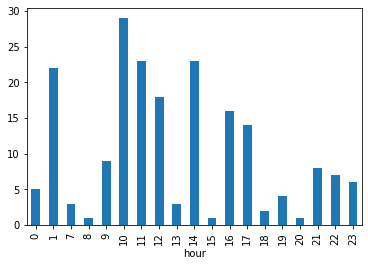

In [21]:
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

## Q 4) 
## What is the difference in Weekend vs Weekday usage pattern?
## How many words do I type on average on weekday vs weekend?

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html

In [22]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name()) # can use day_name or weekday from datetime 

In [23]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])

In [24]:
msgs_per_user = df['user'].value_counts(sort=True)
msgs_per_user

+91 99865 06076             295
Papa                        195
Adarsh Bhaiya               157
Shamsia                     150
+91 74186 09457             134
+91 94658 31285             105
Gaurav 408                   95
+91 81055 57766              75
Mahesh 415                   75
411 Oyolife 1570             71
Dr Jay Flipkart              64
Arbaz Oyo Supervisor         61
Rahul Oyo Life               50
Saurav Sir 505               45
Ganesh Supervisor            40
+91 89033 57556              37
+91 99032 11464              36
+91 91486 71444              27
Punjaab De Puttar            27
+91 93113 56939              21
+91 91102 66076              17
106 Oyolife                  16
+91 85560 73035              13
Shehraz Bhaiya               13
+91 70058 30051              13
210 Syed Bhaiya               9
Arnab Das Bhaiya Oyolife      7
Krishna 303                   7
+91 95618 30358               6
+91 98196 03217               6
+91 82968 86915               5
Abhishek

In [25]:
top5_users = msgs_per_user.index.tolist()[:5]
top5_users

['+91 99865 06076', 'Papa', 'Adarsh Bhaiya', 'Shamsia', '+91 74186 09457']

In [26]:
df_top5 = df.copy()
df_top5 = df_top5[df_top5.user.isin(top5_users)]
df_top5.head()

,date_time,user,msg,hour,weekday,is_weekend
9,2019-12-04 22:39:00,Adarsh Bhaiya,They are playing @919911200329,22,Wednesday,False
11,2019-12-04 22:46:00,Adarsh Bhaiya,Ambish gaurav etc,22,Wednesday,False
12,2019-12-04 23:07:00,Adarsh Bhaiya,https://www.freepressjournal.in/business/adity...,23,Wednesday,False
17,2019-12-04 23:42:00,Papa,New form of sardi,23,Wednesday,False
18,2019-12-04 23:42:00,Papa,😅😅,23,Wednesday,False


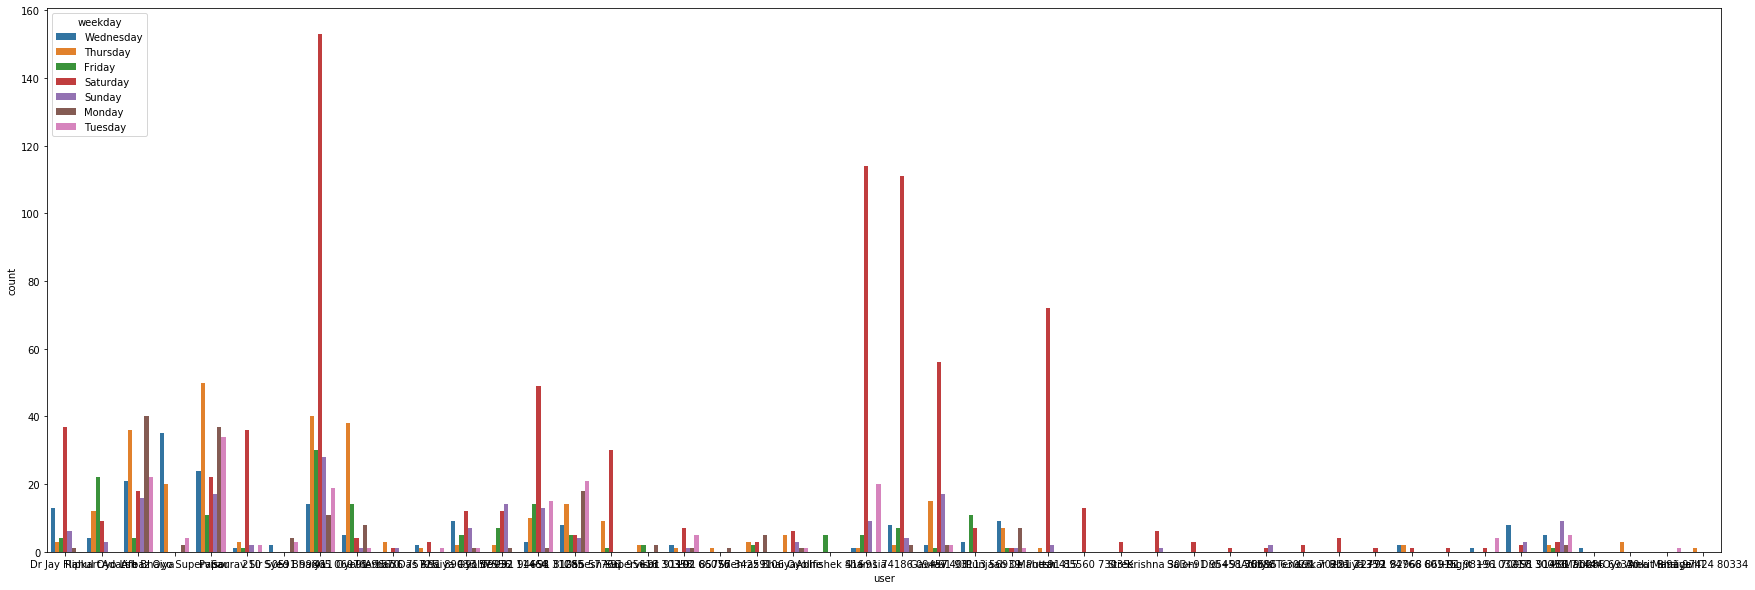

In [27]:
plt.figure(figsize=(30,10))
sns.countplot(x="user", hue="weekday", data=df)

In [28]:
df_top5['is_weekend'] = df_top5.weekday.isin(['Sunday', 'Saturday'])

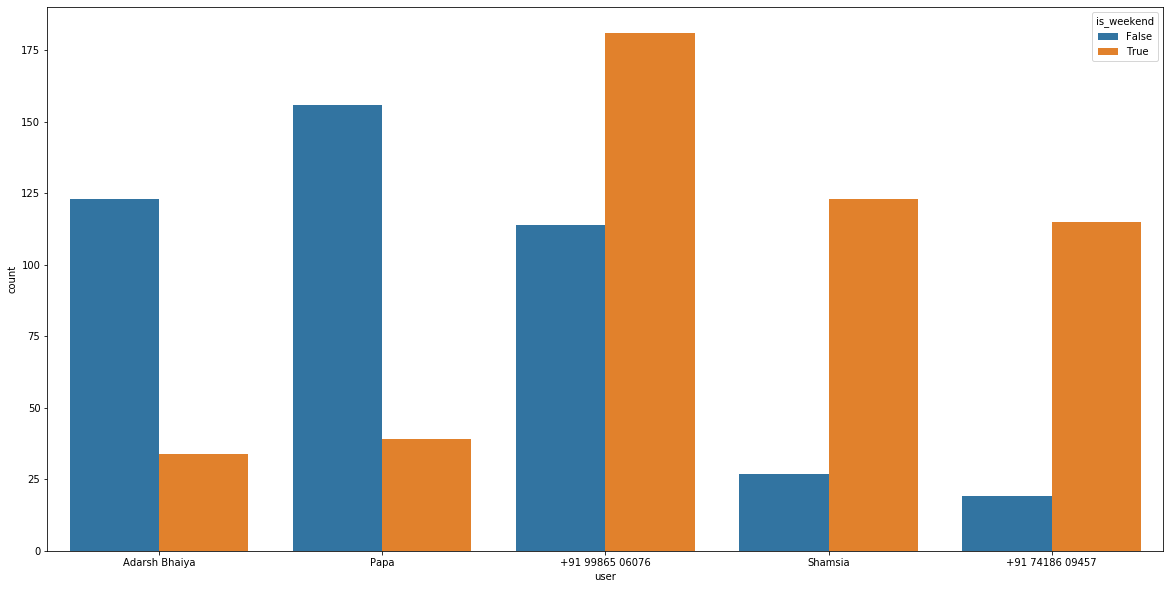

In [29]:
plt.figure(figsize=(20,10))
sns.countplot(x="user", hue="is_weekend", data=df_top5)

In [30]:
def word_count(val):
    return len(val.split())

In [31]:
df['no_of_words'] = df['msg'].apply(word_count)

In [32]:
df_top5['no_of_words'] = df_top5['msg'].apply(word_count)

In [33]:
total_words_weekday = df[df['is_weekend']==False]['no_of_words'].sum()
total_words_weekday

4939

In [34]:
total_words_weekend = df[df['is_weekend']]['no_of_words'].sum()
total_words_weekend

6932

In [35]:
total_words_weekday/5 # average words on a weekday

987.8

In [36]:
total_words_weekend/2 # average words on a weekend

3466.0

In [37]:
df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)

user
Shamsia                     1930
+91 99865 06076             1859
Papa                         978
+91 94658 31285              845
Adarsh Bhaiya                748
+91 74186 09457              692
Gaurav 408                   529
+91 81055 57766              442
Saurav Sir 505               370
411 Oyolife 1570             363
Rahul Oyo Life               353
Mahesh 415                   349
Ganesh Supervisor            328
+91 99032 11464              269
Dr Jay Flipkart              245
Arbaz Oyo Supervisor         177
Punjaab De Puttar            177
+91 89033 57556              136
+91 91102 66076              124
+91 91486 71444              124
+91 93113 56939              123
+91 85560 73035               97
106 Oyolife                   94
+91 70058 30051               65
Shehraz Bhaiya                65
+91 95618 30358               62
210 Syed Bhaiya               47
Krishna 303                   47
+91 98196 03217               42
+91 96636 75725               20
Manis

In [38]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

user
Shamsia            12.866667
+91 99865 06076     6.301695
+91 74186 09457     5.164179
Papa                5.015385
Adarsh Bhaiya       4.764331
dtype: float64

In [39]:
wordPerMsg_weekday_vs_weekend = (df_top5.groupby(['user', 'is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user', 'is_weekend']).size())
wordPerMsg_weekday_vs_weekend

user             is_weekend
+91 74186 09457  False          3.052632
                 True           5.513043
+91 99865 06076  False          5.307018
                 True           6.928177
Adarsh Bhaiya    False          5.024390
                 True           3.823529
Papa             False          5.153846
                 True           4.461538
Shamsia          False          6.296296
                 True          14.308943
dtype: float64

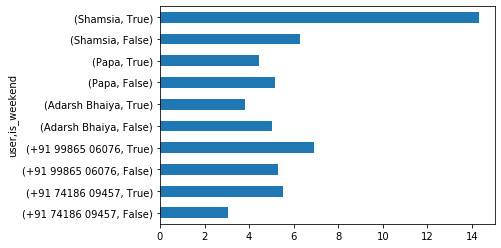

In [40]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh')

## Q 5)
## Most Usage - Time of Day

In [41]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,2.0,15.0,NaN,NaN,50.0,NaN,NaN
1,NaN,NaN,12.0,NaN,70.0,NaN,2.0
2,NaN,NaN,5.0,NaN,1.0,NaN,3.0
3,NaN,1.0,2.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.0


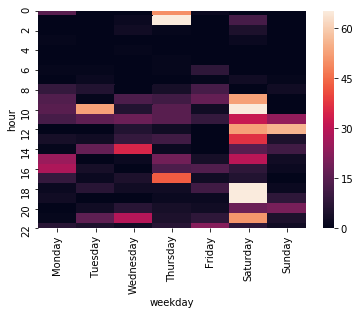

In [42]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(x2[days].fillna(0), robust=True)

## Q 6)
## In any group, do I have any inclination towards responding to someone? 

In [43]:
my_msgs_index = np.array(df[df['user']==me].index)
print(my_msgs_index, my_msgs_index.shape)

[  17   18   24   78   82   96  105  107  109  111  115  116  119  121
  122  123  125  130  135  137  139  143  151  152  153  155  156  157
  206  219  221  223  241  242  244  245  252  297  305  306  444  580
  609  615  618  619  732  810  896  918  963  965 1045 1070 1161 1162
 1185 1186 1190 1195 1196 1197 1198 1199 1204 1205 1215 1228 1230 1232
 1233 1238 1290 1313 1315 1319 1322 1324 1325 1326 1328 1329 1331 1332
 1336 1337 1340 1347 1348 1350 1353 1356 1357 1380 1381 1382 1388 1404
 1420 1422 1424 1435 1436 1438 1439 1443 1444 1445 1446 1457 1458 1459
 1460 1461 1462 1463 1464 1465 1467 1468 1485 1513 1514 1537 1539 1545
 1548 1549 1550 1559 1560 1563 1565 1566 1568 1574 1609 1612 1614 1615
 1617 1618 1619 1620 1622 1625 1628 1639 1646 1648 1666 1667 1670 1671
 1673 1676 1677 1678 1679 1680 1704 1705 1706 1710 1714 1716 1762 1765
 1772 1773 1774 1780 1781 1782 1797 1805 1806 1809 1810 1812 1818 1819
 1822 1823 1824 1825 1827 1850 1858 1867 1882 1883 1887 1888 1891] (195,)


In [44]:
prev_msgs_index = my_msgs_index - 1
print(prev_msgs_index, prev_msgs_index.shape)

[  16   17   23   77   81   95  104  106  108  110  114  115  118  120
  121  122  124  129  134  136  138  142  150  151  152  154  155  156
  205  218  220  222  240  241  243  244  251  296  304  305  443  579
  608  614  617  618  731  809  895  917  962  964 1044 1069 1160 1161
 1184 1185 1189 1194 1195 1196 1197 1198 1203 1204 1214 1227 1229 1231
 1232 1237 1289 1312 1314 1318 1321 1323 1324 1325 1327 1328 1330 1331
 1335 1336 1339 1346 1347 1349 1352 1355 1356 1379 1380 1381 1387 1403
 1419 1421 1423 1434 1435 1437 1438 1442 1443 1444 1445 1456 1457 1458
 1459 1460 1461 1462 1463 1464 1466 1467 1484 1512 1513 1536 1538 1544
 1547 1548 1549 1558 1559 1562 1564 1565 1567 1573 1608 1611 1613 1614
 1616 1617 1618 1619 1621 1624 1627 1638 1645 1647 1665 1666 1669 1670
 1672 1675 1676 1677 1678 1679 1703 1704 1705 1709 1713 1715 1761 1764
 1771 1772 1773 1779 1780 1781 1796 1804 1805 1808 1809 1811 1817 1818
 1821 1822 1823 1824 1826 1849 1857 1866 1881 1882 1886 1887 1890] (195,)


In [45]:
df_replies = df.iloc[prev_msgs_index].copy()
df_replies.shape

(195, 7)

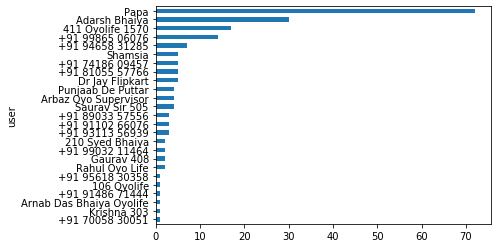

In [46]:
df_replies.groupby(["user"])["msg"].size().sort_values().plot(kind='barh')

## Q 7)
## Which are the most common words?

In [47]:
comment_words = ' '
stopwords = STOPWORDS.update(['lo', 'ge', 'Lo', 'illa', 'yea', 'ella', 'en', 'na', 'En', 'yeah', 'alli', 'ide', 'okay', 'ok', 'will'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 


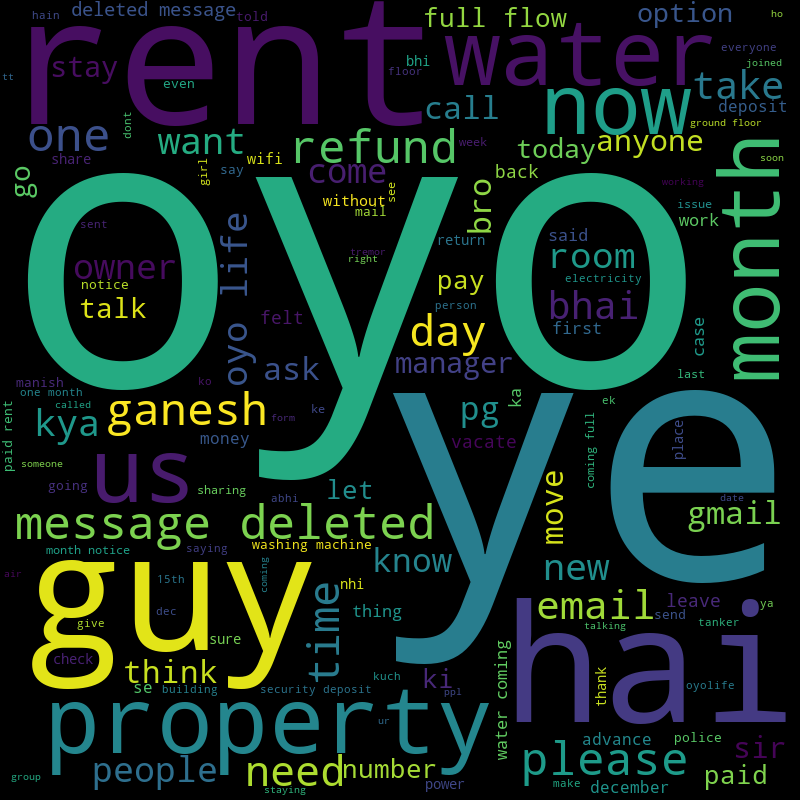

In [48]:
wordcloud.to_image()

## Know What They Know(atleast by little
* Let this meetup series encourage people to work on their own data:
    * Ask many questions on whatsapp chat data, commit to jovian with your answers/analysis visulization. Experiment!!!
* Explore more data resources here's a list i could find, share if you find any @ dsnet.org
    * WhatsApp
    * Google take out (https://takeout.google.com/)
        * Keyboard
        * Maps
        * Calendar 
        * Chrome
        * Pay
        * etc....
    * https://www.cnet.com/how-to/how-to-download-all-your-instagram-data/
    * https://in.pcmag.com/software/120204/how-to-download-your-facebook-data-and-6-surprising-things-i-found
* Lets move step by step EDA first to try answer the questions on our own then move to some ML/DL Models 

## Assingment-kind
* 1way ya 2way, check for a response time between two people

In [ ]:
jovian.commit(notebook_id='PrajwalPrashanth/kwtk-whatsapp-refrence')

[jovian] Saving notebook..


<IPython.core.display.Javascript object>

[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: 

[jovian] Error: The current API key is invalid or expired.
